## **Reinforcement Learning Solver for Pricing Simple Bermudan Put Options for only *1* Intermediate Decision Points**

In [ ]:
!pip install QuantLib
!pip install -q tf-agents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Analytical Solutions - Binomial Tree Option Pricing Method**

In [ ]:
import QuantLib as ql 
import pandas as pd
def get_simple_bermudan_option(): 
    maturity = ql.Date(31, 12, 2022)
    S0=5
    K = 5
    r = 0.03
    sigma = 0.10
    d = 0.0
    otype = ql.Option.Put
    dc = ql.Actual365Fixed()
    calendar = ql.NullCalendar()

    today = ql.Date(1, 1, 2021)
    bermudan = ql.Date(1,1,2022)
    ql.Settings.instance().evaluationDate = today

    payoff = ql.PlainVanillaPayoff(otype, K)

    bermudan_exercise = ql.BermudanExercise([today, bermudan, maturity])
    bermudan_option=ql.VanillaOption(payoff, bermudan_exercise)

    american_exercise = ql.AmericanExercise(today, maturity)
    american_option = ql.VanillaOption(payoff, american_exercise)

    d_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, d, dc))
    r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, dc))
    sigma_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, sigma, dc))
    bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(S0)), d_ts, r_ts, sigma_ts)

    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", 100)
    bermudan_option.setPricingEngine(binomial_engine)
    return bermudan_option.NPV()

In [ ]:
pricing_dict = {}
pricing_dict['Simple Bermudan - Binomial Tree'] = get_simple_bermudan_option()
pricing_df = pd.DataFrame.from_dict(pricing_dict, orient='index')
pricing_df.columns = ['Option Price']
print(pricing_df)

                                 Option Price
Simple Bermudan - Binomial Tree       0.16845


**Using Reinforcement Learning Solver to Solve Simple Bermudan Put Option Prices**

**Deep-Q Network**

In [ ]:
!pip install -q tf-agents
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 25.4 MB/s 


In [ ]:
import matplotlib.pyplot as plt
from tf_agents.policies import policy_saver
import tempfile
import random
import os
from tf_agents.utils import common  # loss function
from tf_agents.trajectories import trajectory  # s->s' trajectory
from tf_agents.replay_buffers import tf_uniform_replay_buffer  # replay buffer
from tf_agents.networks import q_network  # Q net
from tf_agents.environments import tf_py_environment  # gym to tf gym
from tf_agents.environments import gym_wrapper  # wrap OpenAI gym
from tf_agents.agents.dqn import dqn_agent  # DQN Agent
from tf_agents.agents.ppo import ppo_agent #PPO agent
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.networks.value_network import ValueNetwork
from tensorflow.keras.activations import gelu
from tensorflow_addons.optimizers import Yogi
import tensorflow as tf
import numpy as np
import gym
import QuantLib as ql  # used for calculating the price of option if we hold it, baseline

# Bermudan Put Gym Environment
class BermudanOptionEnv(gym.Env): #Bermudan Put
    def __init__(self):
        self.S0 = 5.0
        self.K = 5.0
        self.r = 0.03
        self.sigma = 0.10
        self.T = 2.0
        self.N = 730    # 500 days
        self.S1 = 0
        self.reward = 0
        self.current_day = 0    # from day 0 taking N steps to day N

        self.action_space = gym.spaces.Discrete(2)         # 0: hold, 1:exercise, the action space, the RL should learn it
        self.observation_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array(
            [np.inf, 1.0]), dtype=np.float32)      # S in [0, inf], tao in [0, 1]

    def step(self, action):
        if action == 1:        # we exercise the option
            reward = max(self.K-self.S1, 0.0) * np.exp(-self.r * self.T * (self.current_day/self.N)) #early payoff
            done = True
        else:       # we hold the option, wait to the next exercise date
            if self.current_day == self.N:    # at maturity
                reward = max(self.K-self.S1, 0.0) * np.exp(-self.r * self.T) # payoff after discouted
                done = True
            else:  # move to the next exercise date
                reward = 0 # no payoff
                # lnS1 - lnS0 = (r - 1/2*sigma^2)*t + sigma * Wt: GBM stock path solution.
                self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.current_day/self.N) + self.sigma * np.sqrt(self.current_day/self.N) * np.random.normal()) #GBM process price
                self.current_day += 365
                done = False # move to next time

        tao = 1.0 - self.current_day/self.N       # time to maturity, in unit of fraction of total_length
        return np.array([self.S1, tao]), reward, done, {}

    def reset(self):
        self.current_day = 0
        self.S1 = self.S0
        tao = 1.0 - self.current_day/self.N     # time to maturity, in unit of fraction of total_length
        return [self.S1, tao]

Text(0.5, 1.0, 'GBM Processes - 10 sample paths')

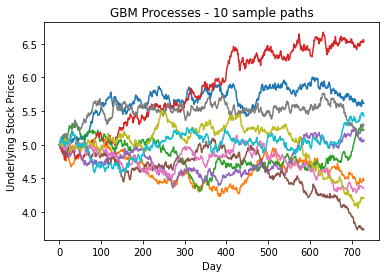

In [ ]:
# monte-carlo simulation of stock prices
prices = []
S1 = 5
r = 0.03
sigma = 0.10
N = 730
T = 2.0
current_day = 0
for j in range(10):
  for i in range(N):
    prices.append(S1)
    S1 = S1 * np.exp((r - 0.5 * sigma**2) * (T/N) + sigma * np.sqrt(T/N) * np.random.normal()) #GBM process price
  plt.plot(prices)
  prices = []
  S1 = 5
  # current_day += 365
plt.xlabel('Day')
plt.ylabel('Underlying Stock Prices')
plt.title("GBM Processes - 10 sample paths")

**Deep Q Network**

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 0.006929691880941391
step = 400: loss = 0.010454745963215828
step = 600: loss = 0.008971500210464
step = 800: loss = 0.007425240240991116
step = 1000: loss = 0.008744623512029648
step = 1000: Average Return = 0.08278129994869232
step = 1200: loss = 0.009004545398056507
step = 1400: loss = 0.010528857819736004
step = 1600: loss = 0.0061349933966994286
step = 1800: loss = 0.0065862336196005344
step = 2000: loss = 0.006593839731067419
step = 2000: Average Return = 0.2215465009212494
step = 2200: loss = 0.0035015123430639505
step = 2400: loss = 0.004733758512884378
step = 2600: loss = 0.003541000420227647
step = 2800: loss = 0.005625464022159576
step = 

INFO:tensorflow:Assets written to: /tmp/policy/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: /tmp/policy/assets


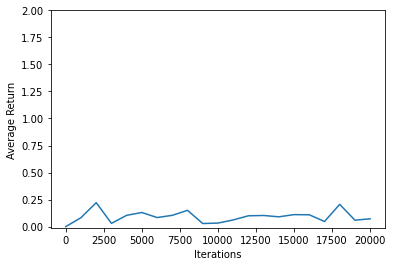

In [ ]:
# Hyper-parameters
num_iterations = 20000  # @param {type:"integer"}

collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 256  # @param {type:"integer"}

learning_rate = 1e-3  # @param {type:"number"}
num_eval_episodes = 10  # @param {type:"integer"}

eval_interval = 1000  # @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}

train_env_gym = BermudanOptionEnv() # american put env
eval_env_gym = BermudanOptionEnv() # test case

train_env_wrap = gym_wrapper.GymWrapper(train_env_gym)
eval_env_wrap = gym_wrapper.GymWrapper(eval_env_gym)

train_env = tf_py_environment.TFPyEnvironment(train_env_wrap)
eval_env = tf_py_environment.TFPyEnvironment(eval_env_wrap)

fc_layer_params = (100,) # number of hidden layers

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# the buffer will update the Q table based on not only the past one step, but some older steps as well.

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# eval_env evaluation

# computer average return of the Q network, which in our case is the reward, which is premium option price
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for i in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# Data Collection

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

# common loop in RL- especailly DQN
def collect_data(env, policy, buffer, steps):
    for i in range(steps):
        collect_step(env, policy, buffer)

# training!!
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for i in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for j in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

# plot training iterations
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2)

# save policy
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

saved_policy = tf.compat.v2.saved_model.load(policy_dir)

In [ ]:
npv = compute_avg_return(eval_env, agent.policy, num_episodes=10000) # 10000 path
pricing_dict['RL-DQN - 10000 Path'] = npv
pricing_dict

{'RL-DQN - 10000 Path': 0.10072408,
 'Simple Bermudan - Binomial Tree': 0.1685054169178282}

In [ ]:
npv = compute_avg_return(eval_env, agent.policy, num_episodes=100) # 100 path
pricing_dict['RL-DQN - 100 Path'] = npv
npv = compute_avg_return(eval_env, agent.policy, num_episodes=1000) # 1000 path
pricing_dict['RL-DQN - 1000 Path'] = npv
# npv = compute_avg_return(eval_env, agent.policy, num_episodes=100000) # 100000 path
# pricing_dict['RL-DQN - 100000 Path'] = npv

In [ ]:
pricing_dict

{'RL-DQN - 100 Path': 0.09484039,
 'RL-DQN - 1000 Path': 0.09903693,
 'Simple Bermudan - Binomial Tree': 0.16844989996356916}

**Double Deep Q Network**

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


step = 200: loss = 0.007318985648453236
step = 400: loss = 0.004914357326924801
step = 600: loss = 0.008899414911866188
step = 800: loss = 0.008989217691123486
step = 1000: loss = 0.008832154795527458
step = 1000: Average Return = 0.0008396123303100467
step = 1200: loss = 0.0050729564391076565
step = 1400: loss = 0.007944485172629356
step = 1600: loss = 0.006655403412878513
step = 1800: loss = 0.002653733128681779
step = 2000: loss = 0.008516775444149971
step = 2000: Average Return = 0.1558341532945633
step = 2200: loss = 0.006579430773854256
step = 2400: loss = 0.0049057030119001865
step = 2600: loss = 0.003363823750987649
step = 2800: loss = 0.006345344707369804
step = 3000: loss = 0.004293972626328468
step = 3000: Average Return = 0.018200621008872986
step = 3200: loss = 0.004928006790578365
step = 3400: loss = 0.004779922775924206
step = 3600: loss = 0.007553691975772381
step = 3800: loss = 0.01154407113790512
step = 4000: loss = 0.0076934886164963245
step = 4000: Average Return = 

INFO:tensorflow:Assets written to: /tmp/policy/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: /tmp/policy/assets


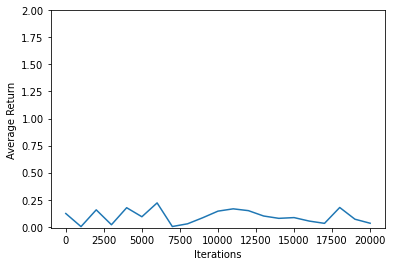

In [ ]:
tf.random.set_seed(1234)
# Hyper-parameters
num_iterations = 20000  # @param {type:"integer"}

collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 256  # @param {type:"integer"}

learning_rate = 1e-3  # @param {type:"number"}
num_eval_episodes = 10  # @param {type:"integer"}

eval_interval = 1000  # @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}

train_env_gym = BermudanOptionEnv() # american put env
eval_env_gym = BermudanOptionEnv() # test case

train_env_wrap = gym_wrapper.GymWrapper(train_env_gym)
eval_env_wrap = gym_wrapper.GymWrapper(eval_env_gym)

train_env = tf_py_environment.TFPyEnvironment(train_env_wrap)
eval_env = tf_py_environment.TFPyEnvironment(eval_env_wrap)

fc_layer_params = (100,) # number of hidden layers

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# the buffer will update the Q table based on not only the past one step, but some older steps as well.

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# eval_env evaluation

# computer average return of the Q network, which in our case is the reward, which is premium option price
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for i in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# Data Collection

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

# common loop in RL- especailly DQN
def collect_data(env, policy, buffer, steps):
    for i in range(steps):
        collect_step(env, policy, buffer)

# training!!
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for i in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for j in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

# plot training iterations
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2)

# save policy
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

saved_policy = tf.compat.v2.saved_model.load(policy_dir)

In [ ]:
npv = compute_avg_return(eval_env, agent.policy, num_episodes=10000)
pricing_dict['RL-DQQN - 10000 Path'] = npv
pricing_dict

{'RL-DQN - 100 Path': 0.09484039,
 'RL-DQN - 1000 Path': 0.09903693,
 'RL-DQQN - 10000 Path': 0.10197765,
 'Simple Bermudan - Binomial Tree': 0.16844989996356916}

**PPO Agent**

In [ ]:
# Hyper-parameters
num_iterations = 20000  # @param {type:"integer"}

collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 2500  # @param {type:"integer"}
batch_size = 256  # @param {type:"integer"}

learning_rate = 1e-3  # @param {type:"number"}
num_eval_episodes = 10  # @param {type:"integer"}

eval_interval = 1000  # @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}

train_env_gym = BermudanOptionEnv() # american put env
eval_env_gym = BermudanOptionEnv() # test case

train_env_wrap = gym_wrapper.GymWrapper(train_env_gym)
eval_env_wrap = gym_wrapper.GymWrapper(eval_env_gym)

train_env = tf_py_environment.TFPyEnvironment(train_env_wrap)
eval_env = tf_py_environment.TFPyEnvironment(eval_env_wrap)

# 2. Constructing the Networks: Critic & Value.
conv_layers = None
fc_layers = [256, 256]
train_step = tf.Variable(initial_value=0)
actor_network = ActorDistributionNetwork(
    input_tensor_spec=train_env.observation_spec(),
    output_tensor_spec=train_env.action_spec(),
    conv_layer_params=conv_layers,
    fc_layer_params=fc_layers,
    activation_fn=gelu
)

value_network = ValueNetwork(
    input_tensor_spec=train_env.observation_spec(),
    conv_layer_params=conv_layers,
    fc_layer_params=fc_layers,
    activation_fn=gelu
)

# optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = Yogi(learning_rate=0.00025)
#clipping_epsilon = 0.1
td_lambda = 0.95
gamma = 0.99
num_epochs = 10
#use_gae = True
#entropy_coef = 0.005

agent = ppo_agent.PPOAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    optimizer=optimizer,
    actor_net=actor_network,
    value_net=value_network,
#    importance_ratio_clipping=clipping_epsilon,
    lambda_value=td_lambda,
    discount_factor=gamma,
#    entropy_regularization=entropy_coef,
#    use_gae=use_gae,
    num_epochs=num_epochs,
    train_step_counter=train_step
)

agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# the buffer will update the Q table based on not only the past one step, but some older steps as well.

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# eval_env evaluation

# computer average return of the Q network, which in our case is the reward, which is premium option price
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for i in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# Data Collection

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

# common loop in RL- especailly DQN
def collect_data(env, policy, buffer, steps):
    for i in range(steps):
        collect_step(env, policy, buffer)

# training!!
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for i in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for j in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        # save policy
        tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
        policy_dir = os.path.join(tempdir, 'policy')
        tf_policy_saver = policy_saver.PolicySaver(agent.policy)
        tf_policy_saver.save(policy_dir)

        saved_policy = tf.compat.v2.saved_model.load(policy_dir)

# plot training iterations
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2)

# save policy
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

saved_policy = tf.compat.v2.saved_model.load(policy_dir)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


step = 200: loss = 0.13657960295677185
step = 400: loss = -0.039122067391872406
step = 600: loss = 0.3172760307788849
step = 800: loss = 0.5384962558746338
step = 1000: loss = 0.35453471541404724
step = 1000: Average Return = 0.06383291631937027


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 1200: loss = 0.4345945417881012
step = 1400: loss = 0.1441502869129181
step = 1600: loss = 0.1874113380908966
step = 1800: loss = 0.11457064747810364
step = 2000: loss = 0.44297051429748535
step = 2000: Average Return = 0.04190125688910484


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 2200: loss = 0.3111964166164398
step = 2400: loss = 0.10341902822256088
step = 2600: loss = 0.1006758064031601
step = 2800: loss = 0.15501634776592255
step = 3000: loss = 0.22402936220169067
step = 3000: Average Return = 0.01745353266596794


INFO:tensorflow:Assets written to: /tmp/policy/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 3200: loss = 0.16677585244178772
step = 3400: loss = 0.12372611463069916
step = 3600: loss = 0.19889238476753235
step = 3800: loss = 0.25193101167678833
step = 4000: loss = 0.1527845710515976
step = 4000: Average Return = 0.10168111324310303


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 4200: loss = 0.20523428916931152
step = 4400: loss = 0.22468361258506775
step = 4600: loss = 0.1904739886522293
step = 4800: loss = 0.2992331385612488
step = 5000: loss = 0.22041404247283936
step = 5000: Average Return = 0.09086257219314575


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 5200: loss = 0.27642327547073364
step = 5400: loss = 0.17335611581802368
step = 5600: loss = 0.1591019332408905
step = 5800: loss = 0.292421817779541
step = 6000: loss = 0.21563822031021118
step = 6000: Average Return = 0.08574571460485458


INFO:tensorflow:Assets written to: /tmp/policy/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 6200: loss = 0.23651579022407532
step = 6400: loss = 0.22646808624267578
step = 6600: loss = 0.31767889857292175
step = 6800: loss = 0.11764249205589294
step = 7000: loss = 0.12372787296772003
step = 7000: Average Return = 0.036849986761808395


INFO:tensorflow:Assets written to: /tmp/policy/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 7200: loss = 0.19086897373199463
step = 7400: loss = 0.26087915897369385
step = 7600: loss = 0.20855779945850372
step = 7800: loss = 0.2973363399505615
step = 8000: loss = 0.33139723539352417
step = 8000: Average Return = 0.12670768797397614


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 8200: loss = 0.21031861007213593
step = 8400: loss = 0.20950767397880554
step = 8600: loss = 0.2140866369009018
step = 8800: loss = 0.22094886004924774
step = 9000: loss = 0.14067992568016052
step = 9000: Average Return = 0.06395238637924194


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 9200: loss = 0.2986491918563843
step = 9400: loss = 0.19179925322532654
step = 9600: loss = 0.1883305460214615
step = 9800: loss = 0.17561747133731842
step = 10000: loss = 0.20667767524719238
step = 10000: Average Return = 0.1729131042957306


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 10200: loss = 0.3152913451194763
step = 10400: loss = 0.15011794865131378
step = 10600: loss = 0.21752241253852844
step = 10800: loss = 0.23612971603870392
step = 11000: loss = 0.09867341816425323
step = 11000: Average Return = 0.08154674619436264


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 11200: loss = 0.30636852979660034
step = 11400: loss = 0.22061389684677124
step = 11600: loss = 0.12256182730197906
step = 11800: loss = 0.1941087543964386
step = 12000: loss = 0.24901895225048065
step = 12000: Average Return = 0.07665779441595078


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 12200: loss = 0.15673457086086273
step = 12400: loss = 0.16606755554676056
step = 12600: loss = 0.21756406128406525
step = 12800: loss = 0.10126706957817078
step = 13000: loss = 0.1950487345457077
step = 13000: Average Return = 0.21859999001026154


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 13200: loss = 0.12795047461986542
step = 13400: loss = 0.16562779247760773
step = 13600: loss = 0.18070350587368011
step = 13800: loss = 0.2197248637676239
step = 14000: loss = 0.15284712612628937
step = 14000: Average Return = 0.14327669143676758


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 14200: loss = 0.17796289920806885
step = 14400: loss = 0.19420146942138672
step = 14600: loss = 0.213609516620636
step = 14800: loss = 0.22474482655525208
step = 15000: loss = 0.21791888773441315
step = 15000: Average Return = 0.1569899022579193


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 15200: loss = 0.2391628473997116
step = 15400: loss = 0.2718994617462158
step = 15600: loss = 0.2819845974445343
step = 15800: loss = 0.23406405746936798
step = 16000: loss = 0.4052269458770752
step = 16000: Average Return = 0.07469187676906586


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 16200: loss = 0.22705894708633423
step = 16400: loss = 0.20025552809238434
step = 16600: loss = 0.1559785157442093
step = 16800: loss = 0.19021940231323242
step = 17000: loss = 0.22875261306762695
step = 17000: Average Return = 0.11093215644359589


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 17200: loss = 0.3023195266723633
step = 17400: loss = 0.1850292682647705
step = 17600: loss = 0.22554068267345428
step = 17800: loss = 0.17256319522857666
step = 18000: loss = 0.2730114459991455
step = 18000: Average Return = 0.10644765943288803


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 18200: loss = 0.23222678899765015
step = 18400: loss = 0.2487606257200241
step = 18600: loss = 0.2536862790584564
step = 18800: loss = 0.2984355092048645
step = 19000: loss = 0.14902155101299286
step = 19000: Average Return = 0.012897792272269726


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 19200: loss = 0.19113090634346008
step = 19400: loss = 0.23745110630989075
step = 19600: loss = 0.1507067233324051
step = 19800: loss = 0.19278112053871155
step = 20000: loss = 0.22667014598846436
step = 20000: Average Return = 0.11581043899059296


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


step = 20200: loss = 0.15218129754066467
step = 20400: loss = 0.1780589073896408
step = 20600: loss = 0.1864302158355713
step = 20800: loss = 0.18791726231575012
step = 21000: loss = 0.17231744527816772
step = 21000: Average Return = 0.13622918725013733


KeyboardInterrupt: ignored

In [ ]:
npv = compute_avg_return(eval_env, agent.policy, num_episodes=10000) # 10000 path
pricing_dict['RL-PPO - 10000 Path'] = npv
pricing_dict

{'RL-PPO - 10000 Path': 0.098266214,
 'Simple Bermudan - Binomial Tree': 0.16844989996356916}

## **Reinforcement Learning Solver for Pricing Bermudan Put Options with *10* Intermediate Decision Points**

**Analytical Solutions - Binomial Tree Option Pricing Method**

In [ ]:
import QuantLib as ql 
import pandas as pd
def get_bermudan_option_with_11_points(): 
    maturity = ql.Date(1, 3, 2023)
    S0=5
    K = 5
    r = 0.03
    sigma = 0.10
    d = 0.0
    otype = ql.Option.Put
    dc = ql.Actual365Fixed()
    calendar = ql.NullCalendar()

    today = ql.Date(1, 1, 2021)
    bermudan1 = ql.Date(1,3,2021)
    bermudan2 = ql.Date(1,5,2021)
    bermudan3 = ql.Date(1,7,2021)
    bermudan4 = ql.Date(1,9,2021)
    bermudan5 = ql.Date(1,11,2021)
    bermudan6 = ql.Date(1,1,2022)
    bermudan7 = ql.Date(1,3,2022)
    bermudan8 = ql.Date(1,5,2022)
    bermudan9 = ql.Date(1,7,2022)
    bermudan10 = ql.Date(1,9,2022)
    bermudan11 = ql.Date(1,11,2022)
    ql.Settings.instance().evaluationDate = today

    payoff = ql.PlainVanillaPayoff(otype, K)

    bermudan_exercise = ql.BermudanExercise([bermudan1,bermudan2,bermudan3,bermudan4,bermudan5,bermudan6,bermudan7,bermudan8,bermudan9,bermudan10,bermudan11, maturity])
    bermudan_option=ql.VanillaOption(payoff, bermudan_exercise)

    american_exercise = ql.AmericanExercise(today, maturity)
    american_option = ql.VanillaOption(payoff, american_exercise)

    d_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, d, dc))
    r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, dc))
    sigma_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, sigma, dc))
    bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(S0)), d_ts, r_ts, sigma_ts)

    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", 100)
    bermudan_option.setPricingEngine(binomial_engine)
    return bermudan_option.NPV()

In [ ]:
pricing_dict = {}
pricing_dict['Bermudan Put - Binomial Tree'] = get_bermudan_option_with_11_points()
pricing_df = pd.DataFrame.from_dict(pricing_dict, orient='index')
pricing_df.columns = ['Option Price']
print(pricing_df)

                                                    Option Price
Bermudan Put with 11 Decision Points - Binomial...      0.184841


**Using Reinforcement Learning Solver to Solve Bermudan Put Option with 11 Internmediate Exercising Points**

In [ ]:
import matplotlib.pyplot as plt
from tf_agents.policies import policy_saver
import tempfile
import random
import os
from tf_agents.utils import common  # loss function
from tf_agents.trajectories import trajectory  # s->s' trajectory
from tf_agents.replay_buffers import tf_uniform_replay_buffer  # replay buffer
from tf_agents.networks import q_network  # Q net
from tf_agents.environments import tf_py_environment  # gym to tf gym
from tf_agents.environments import gym_wrapper  # wrap OpenAI gym
from tf_agents.agents.dqn import dqn_agent  # DQN Agent
from tf_agents.agents.ppo import ppo_agent
import tensorflow as tf
import numpy as np
import gym
import QuantLib as ql  # used for calculating the price of option if we hold it, baseline

# Bermudan Put Gym Environment
class BermudanOptionEnv(gym.Env): #Bermudan Put
    def __init__(self):
        self.S0 = 5.0
        self.K = 5.0
        self.r = 0.03
        self.sigma = 0.10
        self.T = 2.0
        self.N = 732   # 732 days

        self.S1 = 0
        self.reward = 0
        self.current_day = 0    # from day 0 taking N steps to day N

        self.action_space = gym.spaces.Discrete(2)         # 0: hold, 1:exercise, the action space, the RL should learn it
        self.observation_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array(
            [np.inf, 1.0]), dtype=np.float32)      # S in [0, inf], tao in [0, 1]

    def step(self, action):
        if action == 1:        # we exercise the option
            reward = max(self.K-self.S1, 0.0) * np.exp(-self.r * self.T * (self.current_day/self.N)) #early payoff
            done = True
        else:       # we hold the option, wait to the next exercise date
            if self.current_day == self.N:    # at maturity
                reward = max(self.K-self.S1, 0.0) * np.exp(-self.r * self.T) # payoff after discouted
                done = True
            else:  # move to tomorrow/next exercise date
                reward = 0 # no payoff
                # lnS1 - lnS0 = (r - 1/2*sigma^2)*t + sigma * Wt: GBM stock path solution.
                self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.current_day/self.N) + self.sigma * np.sqrt(self.current_day/self.N) * np.random.normal()) #GBM process price
                self.current_day += 61
                done = False # move to next time

        tao = 1.0-self.current_day/self.N        # time to maturity, in unit of fraction of total_length
        return np.array([self.S1, tao]), reward, done, {}

    def reset(self):
        self.current_day = 0
        self.S1 = self.S0
        tao = 1.0-self.current_day/self.N        # time to maturity, in unit of fraction of total_length
        return [self.S1, tao]

**Deep Q Network**

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


step = 200: loss = 0.003650132566690445
step = 400: loss = 0.006475348491221666
step = 600: loss = 0.008413203060626984
step = 800: loss = 0.013374561443924904
step = 1000: loss = 0.004942030645906925
step = 1000: Average Return = 0.14340226352214813
step = 1200: loss = 0.005061009433120489
step = 1400: loss = 0.0027110923547297716
step = 1600: loss = 0.003538456279784441
step = 1800: loss = 0.003514025127515197
step = 2000: loss = 0.004538955166935921
step = 2000: Average Return = 0.22681978344917297
step = 2200: loss = 0.0065576015040278435
step = 2400: loss = 0.0043141841888427734
step = 2600: loss = 0.0028684635180979967
step = 2800: loss = 0.004327934235334396
step = 3000: loss = 0.005101171787828207
step = 3000: Average Return = 0.1583210825920105
step = 3200: loss = 0.004643366206437349
step = 3400: loss = 0.006745918653905392
step = 3600: loss = 0.004901840817183256
step = 3800: loss = 0.005919065326452255
step = 4000: loss = 0.004325441550463438
step = 4000: Average Return = 0

step = 20000: Average Return = 0.2329680621623993


INFO:tensorflow:Assets written to: /tmp/policy/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: /tmp/policy/assets


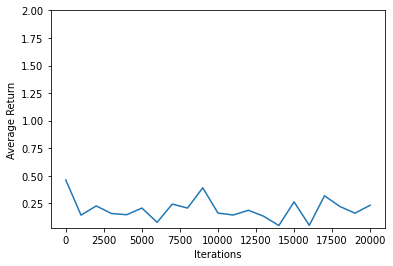

In [ ]:
# Hyper-parameters
num_iterations = 20000  # @param {type:"integer"}

collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 256  # @param {type:"integer"}

learning_rate = 1e-3  # @param {type:"number"}
num_eval_episodes = 10  # @param {type:"integer"}

eval_interval = 1000  # @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}

train_env_gym = BermudanOptionEnv() # american put env
eval_env_gym = BermudanOptionEnv() # test case

train_env_wrap = gym_wrapper.GymWrapper(train_env_gym)
eval_env_wrap = gym_wrapper.GymWrapper(eval_env_gym)

train_env = tf_py_environment.TFPyEnvironment(train_env_wrap)
eval_env = tf_py_environment.TFPyEnvironment(eval_env_wrap)

fc_layer_params = (100,) # number of hidden layers

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# the buffer will update the Q table based on not only the past one step, but some older steps as well.

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# eval_env evaluation

# computer average return of the Q network, which in our case is the reward, which is premium option price
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for i in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# Data Collection

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

# common loop in RL- especailly DQN
def collect_data(env, policy, buffer, steps):
    for i in range(steps):
        collect_step(env, policy, buffer)

# training!!
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for i in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for j in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

# plot training iterations
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2)

# save policy
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

saved_policy = tf.compat.v2.saved_model.load(policy_dir)

In [ ]:
npv = compute_avg_return(eval_env, agent.policy, num_episodes=10000) # 10000 path
pricing_dict['RL-DQN - 10000 Path'] = npv
pricing_dict

{'Bermudan Put with 11 Decision Points - Binomial Tree': 0.18484082892803913,
 'RL-DQN - 100 Path': 0.20071062}

**Double Deep Q Network**

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


step = 200: loss = 0.008041481487452984
step = 400: loss = 0.0032232266385108232
step = 600: loss = 0.009250139817595482
step = 800: loss = 0.0109369782730937
step = 1000: loss = 0.01306467317044735
step = 1000: Average Return = 0.5354942083358765
step = 1200: loss = 0.016467757523059845
step = 1400: loss = 0.012879880145192146
step = 1600: loss = 0.007006361149251461
step = 1800: loss = 0.003891587955877185
step = 2000: loss = 0.008131193928420544
step = 2000: Average Return = 0.1612675040960312
step = 2200: loss = 0.009624606929719448
step = 2400: loss = 0.00528717739507556
step = 2600: loss = 0.004044915083795786
step = 2800: loss = 0.004466997925192118
step = 3000: loss = 0.0045033651404082775
step = 3000: Average Return = 0.12244696915149689
step = 3200: loss = 0.0036306665278971195
step = 3400: loss = 0.005511815659701824
step = 3600: loss = 0.00658235140144825
step = 3800: loss = 0.006338194478303194
step = 4000: loss = 0.00929323397576809
step = 4000: Average Return = 0.2485909

step = 20000: Average Return = 0.2176072597503662


INFO:tensorflow:Assets written to: /tmp/policy/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: /tmp/policy/assets


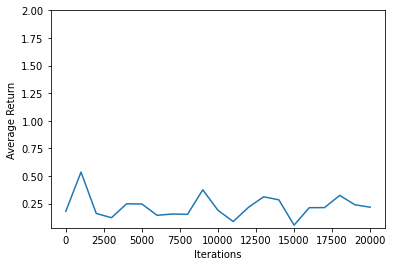

In [ ]:
# Hyper-parameters
num_iterations = 20000  # @param {type:"integer"}

collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 256  # @param {type:"integer"}

learning_rate = 1e-3  # @param {type:"number"}
num_eval_episodes = 10  # @param {type:"integer"}

eval_interval = 1000  # @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}

train_env_gym = BermudanOptionEnv() # american put env
eval_env_gym = BermudanOptionEnv() # test case

train_env_wrap = gym_wrapper.GymWrapper(train_env_gym)
eval_env_wrap = gym_wrapper.GymWrapper(eval_env_gym)

train_env = tf_py_environment.TFPyEnvironment(train_env_wrap)
eval_env = tf_py_environment.TFPyEnvironment(eval_env_wrap)

fc_layer_params = (100,) # number of hidden layers

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# the buffer will update the Q table based on not only the past one step, but some older steps as well.

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# eval_env evaluation

# computer average return of the Q network, which in our case is the reward, which is premium option price
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for i in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# Data Collection

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

# common loop in RL- especailly DQN
def collect_data(env, policy, buffer, steps):
    for i in range(steps):
        collect_step(env, policy, buffer)

# training!!
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for i in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for j in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

# plot training iterations
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2)

# save policy
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

saved_policy = tf.compat.v2.saved_model.load(policy_dir)

In [ ]:
npv = compute_avg_return(eval_env, agent.policy, num_episodes=10000) # 10000 paths
pricing_dict['RL-DDQN - 10000 Path'] = npv
pricing_dict

{'Bermudan Put with 11 Decision Points - Binomial Tree': 0.18484082892803913,
 'RL-DDQN - 100 Path': 0.2136646,
 'RL-DQN - 100 Path': 0.20071062}

**PPO Agent**

In [ ]:
# Hyper-parameters
num_iterations = 20000  # @param {type:"integer"}

collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 256  # @param {type:"integer"}

learning_rate = 1e-3  # @param {type:"number"}
num_eval_episodes = 10  # @param {type:"integer"}

eval_interval = 1000  # @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}

train_env_gym = BermudanOptionEnv() # american put env
eval_env_gym = BermudanOptionEnv() # test case

train_env_wrap = gym_wrapper.GymWrapper(train_env_gym)
eval_env_wrap = gym_wrapper.GymWrapper(eval_env_gym)

train_env = tf_py_environment.TFPyEnvironment(train_env_wrap)
eval_env = tf_py_environment.TFPyEnvironment(eval_env_wrap)

fc_layer_params = (100,) # number of hidden layers

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = ppo_agent.PPOAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# the buffer will update the Q table based on not only the past one step, but some older steps as well.

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# eval_env evaluation

# computer average return of the Q network, which in our case is the reward, which is premium option price
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for i in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# Data Collection

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

# common loop in RL- especailly DQN
def collect_data(env, policy, buffer, steps):
    for i in range(steps):
        collect_step(env, policy, buffer)

# training!!
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for i in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for j in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

# plot training iterations
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2)

# save policy
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

saved_policy = tf.compat.v2.saved_model.load(policy_dir)

In [ ]:
npv = compute_avg_return(eval_env, agent.policy, num_episodes=10000) # 10000 path
pricing_dict['RL-PPO - 10000 Path'] = npv
pricing_dict

## **Reinforcement Learning Solver for Pricing American Put Options**

**Analytical Solutions - Binomial Tree Option Pricing Method**

In [ ]:
import QuantLib as ql 
import pandas as pd
def get_american_put_option(): 
    maturity = ql.Date(1, 1, 2023)
    S0=5
    K = 5
    r = 0.03
    sigma = 0.10
    d = 0.0
    otype = ql.Option.Put
    dc = ql.Actual365Fixed()
    calendar = ql.NullCalendar()

    today = ql.Date(1, 1, 2021)
    ql.Settings.instance().evaluationDate = today

    payoff = ql.PlainVanillaPayoff(otype, K)

    american_exercise = ql.AmericanExercise(today, maturity)
    american_option = ql.VanillaOption(payoff, american_exercise)

    d_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, d, dc))
    r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, dc))
    sigma_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, sigma, dc))
    bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(S0)), d_ts, r_ts, sigma_ts)

    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", 100)
    american_option.setPricingEngine(binomial_engine)
    return american_option.NPV()

In [ ]:
pricing_dict = {}
pricing_dict['American Put - Binomial Tree'] = get_american_put_option()
pricing_df = pd.DataFrame.from_dict(pricing_dict, orient='index')
pricing_df.columns = ['Option Price']
print(pricing_df)

                              Option Price
American Put - Binomial Tree      0.183273


**Using Reinforcement Learning Solver to Solve American Put Options**

In [ ]:
import matplotlib.pyplot as plt
from tf_agents.policies import policy_saver
import tempfile
import random
import os
from tf_agents.utils import common  # loss function
from tf_agents.trajectories import trajectory  # s->s' trajectory
from tf_agents.replay_buffers import tf_uniform_replay_buffer  # replay buffer
from tf_agents.networks import q_network  # Q net
from tf_agents.environments import tf_py_environment  # gym to tf gym
from tf_agents.environments import gym_wrapper  # wrap OpenAI gym
from tf_agents.agents.dqn import dqn_agent  # DQN Agent
from tf_agents.agents.ppo import ppo_agent # PPO Agent
import tensorflow as tf
import numpy as np
import gym
import QuantLib as ql  # used for calculating the price of option if we hold it, baseline

# American Put Gym Environment
class AmericanPutOptionEnv(gym.Env): #American Put
    def __init__(self):
        self.S0 = 5.0
        self.K = 5.0
        self.r = 0.03
        self.sigma = 0.10
        self.T = 2.0
        self.N = 730   # 730 days
        self.S1 = 0
        self.reward = 0
        self.current_day = 0    # from day 0 taking N steps to day N
        self.action_space = gym.spaces.Discrete(2)         # 0: hold, 1:exercise, the action space, the RL should learn it
        self.observation_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array(
            [np.inf, 1.0]), dtype=np.float32)      # S in [0, inf], tao in [0, 1]

    def step(self, action):
        if action == 1:        # we exercise the option
            reward = max(self.K-self.S1, 0.0) * np.exp(-self.r * self.T * (self.current_day/self.N)) #early payoff
            done = True
        else:       # we hold the option, wait to the next exercise date
            if self.current_day == self.N:    # at maturity
                reward = max(self.K-self.S1, 0.0) * np.exp(-self.r * self.T) # payoff after discouted
                done = True
            else:  # move to tomorrow/next exercise date
                reward = 0 # no payoff
                self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
                self.current_day += 1
                done = False # move to next time

        tao = 1.0-self.current_day/self.N        # time to maturity, in unit of years
        return np.array([self.S1, tao]), reward, done, {}

    def reset(self):
        self.current_day = 0
        self.S1 = self.S0
        tao = 1.0-self.current_day/self.N        # time to maturity, in unit of years
        return [self.S1, tao]

**DQN**

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


step = 200: loss = 0.00023643898020964116
step = 400: loss = 0.0006300238310359418
step = 600: loss = 0.0013709557242691517
step = 800: loss = 0.0004812780243810266
step = 1000: loss = 0.001050292165018618
step = 1000: Average Return = 0.25243932008743286
step = 1200: loss = 0.002294923411682248
step = 1400: loss = 0.001324157346971333
step = 1600: loss = 0.0009737137006595731
step = 1800: loss = 0.00033609848469495773
step = 2000: loss = 0.0008918949170038104
step = 2000: Average Return = 0.3274080157279968
step = 2200: loss = 0.001077444525435567
step = 2400: loss = 0.0012682040687650442
step = 2600: loss = 0.001699418993666768
step = 2800: loss = 0.00201292522251606
step = 3000: loss = 0.0015698145143687725
step = 3000: Average Return = 0.286185085773468
step = 3200: loss = 0.0009771451586857438
step = 3400: loss = 0.0015402529388666153
step = 3600: loss = 0.0017577941762283444
step = 3800: loss = 0.0036192203406244516
step = 4000: loss = 0.0034345537424087524
step = 4000: Average R

step = 20000: Average Return = 0.24572274088859558


INFO:tensorflow:Assets written to: /tmp/policy/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: /tmp/policy/assets


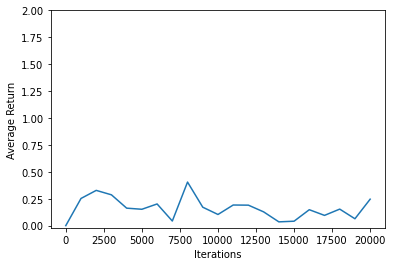

In [ ]:
# Hyper-parameters
num_iterations = 20000  # @param {type:"integer"}

collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 256  # @param {type:"integer"}

learning_rate = 1e-3  # @param {type:"number"}
num_eval_episodes = 10  # @param {type:"integer"}

eval_interval = 1000  # @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}

train_env_gym = AmericanPutOptionEnv() # american put env
eval_env_gym = AmericanPutOptionEnv() # test case

train_env_wrap = gym_wrapper.GymWrapper(train_env_gym)
eval_env_wrap = gym_wrapper.GymWrapper(eval_env_gym)

train_env = tf_py_environment.TFPyEnvironment(train_env_wrap)
eval_env = tf_py_environment.TFPyEnvironment(eval_env_wrap)

fc_layer_params = (100,) # number of hidden layers

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# the buffer will update the Q table based on not only the past one step, but some older steps as well.

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# eval_env evaluation

# computer average return of the Q network, which in our case is the reward, which is premium option price
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for i in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# Data Collection

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

# common loop in RL- especailly DQN
def collect_data(env, policy, buffer, steps):
    for i in range(steps):
        collect_step(env, policy, buffer)

# training!!
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for i in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for j in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

# plot training iterations
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2)

# save policy
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

saved_policy = tf.compat.v2.saved_model.load(policy_dir)

In [ ]:
npv = compute_avg_return(eval_env, agent.policy, num_episodes=10000) # not averaged
pricing_dict['RL-DQN - 10000 Path'] = npv
pricing_dict

{'American Put - Binomial Tree': 0.18327259259578063,
 'RL-DQN - 100 Path': 0.1414174}

**DDQN**

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


step = 200: loss = 0.02021465077996254
step = 400: loss = 0.002763847354799509
step = 600: loss = 0.005606097634881735
step = 800: loss = 0.009201876819133759
step = 1000: loss = 0.0058450354263186455
step = 1000: Average Return = 0.2291295975446701
step = 1200: loss = 0.0059221358969807625
step = 1400: loss = 0.013148041442036629
step = 1600: loss = 0.008572177030146122
step = 1800: loss = 0.0015853152144700289
step = 2000: loss = 0.003436711383983493
step = 2000: Average Return = 0.12069052457809448
step = 2200: loss = 0.00722106359899044
step = 2400: loss = 0.004956073593348265
step = 2600: loss = 0.005854591727256775
step = 2800: loss = 0.005530149210244417
step = 3000: loss = 0.004943207371979952
step = 3000: Average Return = 0.11782469600439072
step = 3200: loss = 0.006120596081018448
step = 3400: loss = 0.007214024662971497
step = 3600: loss = 0.009303277358412743
step = 3800: loss = 0.007136041764169931
step = 4000: loss = 0.006445133127272129
step = 4000: Average Return = 0.20

step = 20000: Average Return = 0.0975307822227478


INFO:tensorflow:Assets written to: /tmp/policy/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: /tmp/policy/assets


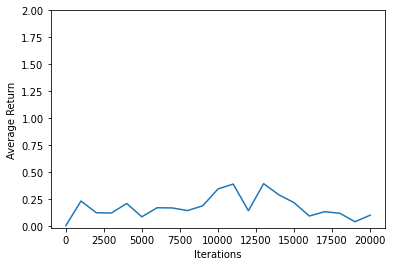

In [ ]:
# Hyper-parameters
num_iterations = 20000  # @param {type:"integer"}

collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 256  # @param {type:"integer"}

learning_rate = 1e-3  # @param {type:"number"}
num_eval_episodes = 10  # @param {type:"integer"}

eval_interval = 1000  # @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}

train_env_gym = BermudanOptionEnv() # american put env
eval_env_gym = BermudanOptionEnv() # test case

train_env_wrap = gym_wrapper.GymWrapper(train_env_gym)
eval_env_wrap = gym_wrapper.GymWrapper(eval_env_gym)

train_env = tf_py_environment.TFPyEnvironment(train_env_wrap)
eval_env = tf_py_environment.TFPyEnvironment(eval_env_wrap)

fc_layer_params = (100,) # number of hidden layers

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# the buffer will update the Q table based on not only the past one step, but some older steps as well.

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# eval_env evaluation

# computer average return of the Q network, which in our case is the reward, which is premium option price
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for i in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# Data Collection

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

# common loop in RL- especailly DQN
def collect_data(env, policy, buffer, steps):
    for i in range(steps):
        collect_step(env, policy, buffer)

# training!!
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for i in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for j in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

# plot training iterations
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2)

# save policy
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

saved_policy = tf.compat.v2.saved_model.load(policy_dir)

In [ ]:
npv = compute_avg_return(eval_env, agent.policy, num_episodes=10000) # 10000 Paths
pricing_dict['RL-DDQN - 10000 Path'] = npv
pricing_dict

{'American Put - Binomial Tree': 0.18327259259578063,
 'RL-DDQN - 100 Path': 0.18708532,
 'RL-DQN - 100 Path': 0.1414174}

**PPO Agent**

In [ ]:
# Hyper-parameters
num_iterations = 20000  # @param {type:"integer"}

collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 256  # @param {type:"integer"}

learning_rate = 1e-3  # @param {type:"number"}
num_eval_episodes = 10  # @param {type:"integer"}

eval_interval = 1000  # @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}

train_env_gym = BermudanOptionEnv() # american put env
eval_env_gym = BermudanOptionEnv() # test case

train_env_wrap = gym_wrapper.GymWrapper(train_env_gym)
eval_env_wrap = gym_wrapper.GymWrapper(eval_env_gym)

train_env = tf_py_environment.TFPyEnvironment(train_env_wrap)
eval_env = tf_py_environment.TFPyEnvironment(eval_env_wrap)

fc_layer_params = (100,) # number of hidden layers

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = ppo_agent.PPOAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# the buffer will update the Q table based on not only the past one step, but some older steps as well.

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# eval_env evaluation

# computer average return of the Q network, which in our case is the reward, which is premium option price
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for i in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# Data Collection

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

# common loop in RL- especailly DQN
def collect_data(env, policy, buffer, steps):
    for i in range(steps):
        collect_step(env, policy, buffer)

# training!!
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for i in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for j in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

# plot training iterations
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2)

# save policy
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

saved_policy = tf.compat.v2.saved_model.load(policy_dir)

In [ ]:
npv = compute_avg_return(eval_env, agent.policy, num_episodes=10000) # 10000 path
pricing_dict['RL-PPO - 10000 Path'] = npv
pricing_dict

# **Build & Abandon Case**

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [813 kB]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates/universe

In [ ]:
!pip install QuantLib
!pip install -q tf-agents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.8 MB 3.6 MB/s 


# **No Abandon**

In [ ]:
import matplotlib.pyplot as plt
from tf_agents.policies import policy_saver
import tempfile
import random
import os
from tf_agents.utils import common  # loss function
from tf_agents.trajectories import trajectory  # s->s' trajectory
from tf_agents.replay_buffers import tf_uniform_replay_buffer  # replay buffer
from tf_agents.networks import q_network  # Q net
from tf_agents.environments import tf_py_environment  # gym to tf gym
from tf_agents.environments import gym_wrapper  # wrap OpenAI gym
from tf_agents.agents.ddpg import ddpg_agent  # DDPG Agent, also some other agents, discussed later
import tensorflow as tf
import numpy as np
import gym
import QuantLib as ql  # used for calculating the price of option if we hold it, baseline

# Build and Abandon Gym Environment
class BuildAbandonOptionEnv(gym.Env): #put
    def __init__(self):
        self.S0 = 100.0
        self.K = 5.0
        self.r = 0.03
        self.sigma = 0.10
        self.T = 2.0
        self.tc = 0.5
        self.gamma = 1.0
        self.Cop = 100.0
        self.Cab = 1.0
        self.tb = 0 # this is our state to observe
        self.N = 500    # 500 day, only do 20 days first

        # 1. at time step t, my abandon happens when E(V_t) < 0, with the abandon and cost
        # 2. 4 states: S, t, ta, tb 
        # 2. we don't have a aboundary for building and abandoning (t > t_b + t_c)
        # 3. Traning Algorithm: States: 1. S, 2. ta, 3. tb

        self.build = False
        self.EV_keep = 0
        self.fb = 100

        self.S1 = 0
        self.reward = 0
        self.current_day = 0    # from day 0 taking N steps to day N
        self.underlying_prices = []
        self.time = []
        self.integral = []
        self.integral_sum = 0
        self.current_day_ratio = self.current_day/(self.N/self.T)
        self.action_space = gym.spaces.Box(low=100, high=105, shape=(1,))    
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 0]), high=np.array(
            [np.inf, 2.0, 2.0]), dtype=np.float32)      # S in [0, inf], tao in [0, 1]

    def step(self, action):
        if self.build == False and self.S1 >= action:   
            self.build = True
            self.tb = self.current_day_ratio
            if self.current_day_ratio == self.T:
              reward = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.current_day_ratio)))
              done = True
            else:
              reward = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.current_day_ratio)))
              self.current_day += 1
              self.current_day_ratio = self.current_day/(self.N/self.T)
              self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
              self.underlying_prices.append(self.S1)
              self.time.append(self.current_day_ratio)
              self.integral.append(np.exp(-self.r * self.time[-1])*self.gamma*(self.underlying_prices[-1]-self.Cop))
              done = False
            # print("If 2")
            self.fb = action
        elif self.build == True:
            if (self.current_day_ratio >= self.tb) and (self.current_day_ratio < (self.tb + self.tc)):
                if self.current_day_ratio == self.T:
                    reward = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.current_day_ratio)))
                    done = True
                else:
                    reward = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.current_day_ratio)))
                    self.current_day += 1
                    self.current_day_ratio = self.current_day/(self.N/self.T)
                    self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
                    self.underlying_prices.append(self.S1)
                    self.time.append(self.current_day_ratio)
                    self.integral.append(np.exp(-self.r * self.time[-1])*self.gamma*(self.underlying_prices[-1]-self.Cop))
                    done = False
            elif (self.current_day_ratio >= (self.tb + self.tc)):
                  self.integral_sum = sum(self.integral)
                  self.EV_keep = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.current_day_ratio))) + self.integral_sum
                  if self.current_day_ratio == self.T:
                      reward = self.EV_keep
                      done = True
                  else:
                      reward = self.EV_keep
                      self.current_day += 1
                      self.current_day_ratio = self.current_day/(self.N/self.T)
                      self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
                      self.underlying_prices.append(self.S1)
                      self.time.append(self.current_day_ratio)
                      self.integral.append(np.exp(-self.r * self.time[-1])*self.gamma*(self.underlying_prices[-1]-self.Cop))
                      done = False
        elif self.build == False and self.S1 < action:   
            if self.current_day_ratio == self.T:
              reward = 0
              done = True
            else:
              reward = 0
              self.current_day += 1
              self.current_day_ratio = self.current_day/(self.N/self.T)
              self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
              self.underlying_prices.append(self.S1)
              self.time.append(self.current_day_ratio)
              self.integral.append(np.exp(-self.r * self.time[-1])*self.gamma*(self.underlying_prices[-1]-self.Cop))
              done = False
        # print(action)
        return np.array([self.S1, self.current_day_ratio, self.tb]), reward, done, {}

    def reset(self):
        self.build = False
        self.tb = 0
        self.current_day = self.tb*(self.N/self.T)
        self.S1 = self.S0
        self.underlying_prices = [0]
        self.time = [0]
        self.integral = [0]
        self.integral_sum = 0
        self.current_day_ratio = self.current_day/(self.N/self.T)
        self.EV_keep = 0
        self.fb = 100
        return [self.S1, self.current_day_ratio, self.tb]

In [ ]:
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
# Hyper-parameters
num_iterations = 20000  # @param {type:"integer"}

collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 256  # @param {type:"integer"}

initial_collect_steps = 2000

learning_rate = 1e-3  # @param {type:"number"}
num_eval_episodes = 10  # @param {type:"integer"}

eval_interval = 1000  # @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}

train_env_gym = BuildAbandonOptionEnv() # american put env
eval_env_gym = BuildAbandonOptionEnv() # test case

train_env_wrap = gym_wrapper.GymWrapper(train_env_gym)
eval_env_wrap = gym_wrapper.GymWrapper(eval_env_gym)

train_env = tf_py_environment.TFPyEnvironment(train_env_wrap)
eval_env = tf_py_environment.TFPyEnvironment(eval_env_wrap)


actor_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
critic_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

act_net = actor_network.ActorNetwork(input_tensor_spec = train_env.observation_spec(),
                                     output_tensor_spec = train_env.action_spec(),
                                     fc_layer_params = (100,),
                                     activation_fn = tf.keras.activations.relu                 
                                     )

crit_net = critic_network.CriticNetwork(input_tensor_spec = (train_env.observation_spec(), train_env.action_spec()),
                                        observation_fc_layer_params = (100,),
                                        action_fc_layer_params = None,
                                        joint_fc_layer_params = (100,),
                                        activation_fn = tf.keras.activations.relu
                                        )
starter_epsilon = 1.0
end_epsilon = 0.5
decay_steps = num_iterations + initial_collect_steps
ou_noise_size = tf.compat.v1.train.polynomial_decay(starter_epsilon,
                                                    train_step_counter,
                                                    decay_steps,
                                                    end_epsilon,
                                                    power=1.0,
                                                    cycle=False)
agent = ddpg_agent.DdpgAgent(time_step_spec = train_env.time_step_spec(),
                             action_spec = train_env.action_spec(),
                             actor_network = act_net,
                             critic_network = crit_net,
                             actor_optimizer = actor_optimizer,
                             critic_optimizer = critic_optimizer, 
                             gamma = 0.99,
                             target_critic_network = None, # Target network = same as primary
                             target_update_tau = 0.1, 
                             ou_stddev = ou_noise_size(), # was 1 
                             ou_damping = 0.25,
                             td_errors_loss_fn = common.element_wise_squared_loss,
                             train_step_counter=train_step_counter
                             )
agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# the buffer will update the Q table based on not only the past one step, but some older steps as well.

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# eval_env evaluation

# computer average return of the Q network, which in our case is the reward, which is premium option price
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for i in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# Data Collection

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

# common loop in RL- especailly DQN
def collect_data(env, policy, buffer, steps):
    for i in range(steps):
        collect_step(env, policy, buffer)

# training!!
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for i in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for j in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}, noise = {2}'.format(step, train_loss, float(np.round(np.array(ou_noise_size()),2))))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

# plot training iterations
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2)

# save policy
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

saved_policy = tf.compat.v2.saved_model.load(policy_dir)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


step = 200: loss = 8204998.0, noise = 1.0
step = 400: loss = 5137481.0, noise = 0.9900000095367432
step = 600: loss = 4025779.0, noise = 0.9900000095367432
step = 800: loss = 3433072.75, noise = 0.9800000190734863
step = 1000: loss = 3996287.25, noise = 0.9800000190734863
step = 1000: Average Return = -111881.75
step = 1200: loss = 4083610.25, noise = 0.9700000286102295
step = 1400: loss = 5037939.0, noise = 0.9700000286102295
step = 1600: loss = 4569550.0, noise = 0.9599999785423279
step = 1800: loss = 3274204.5, noise = 0.9599999785423279
step = 2000: loss = 4157018.25, noise = 0.949999988079071


KeyboardInterrupt: ignored

# **Old Build and Abandon**

In [ ]:
import matplotlib.pyplot as plt
from tf_agents.policies import policy_saver
import tempfile
import random
import os
from tf_agents.utils import common  # loss function
from tf_agents.trajectories import trajectory  # s->s' trajectory
from tf_agents.replay_buffers import tf_uniform_replay_buffer  # replay buffer
from tf_agents.networks import q_network  # Q net
from tf_agents.environments import tf_py_environment  # gym to tf gym
from tf_agents.environments import gym_wrapper  # wrap OpenAI gym
from tf_agents.agents.dqn import dqn_agent  # DQN Agent, also some other agents, discussed later
import tensorflow as tf
import numpy as np
import gym
import QuantLib as ql  # used for calculating the price of option if we hold it, baseline

# Build and Abandon Gym Environment
class BuildAbandonOptionEnv(gym.Env): #put
    def __init__(self):
        self.S0 = 100.0
        self.K = 5.0
        self.r = 0.03
        self.sigma = 0.10
        self.T = 2.0
        self.tc = 0.5
        self.gamma = 1.0
        self.Cop = 100.0
        self.Cab = 1.0
        self.ta = 2.0 # this is our state to observe
        self.tb = 0 # this is our state to observe
        self.N = 500    # 500 day, only do 20 days first

        # 1. at time step t, my abandon happens when E(V_t) < 0, with the abandon and cost
        # 2. 4 states: S, t, ta, tb 
        # 2. we don't have a aboundary for building and abandoning (t > t_b + t_c)
        # 3. Traning Algorithm: States: 1. S, 2. ta, 3. tb

        self.build = False
        self.abandon = False
        self.EV_abandon = 0
        self.EV_keep = 0
        self.fb = 100
        self.fa = 100
        self.panelty = 1.0

        self.S1 = 0
        self.reward = 0
        self.current_day = 0    # from day 0 taking N steps to day N
        self.underlying_prices = []
        self.time = []
        self.integral = []
        self.integral_sum = 0
        self.current_day_ratio = self.current_day/(self.N/self.T)

        self.action_space = gym.spaces.Discrete(2)        
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 0]), high=np.array(
            [np.inf, 2.0, 2.0]), dtype=np.float32)      # S in [0, inf], tao in [0, 1]

    def step(self, action):
        if self.build == False and self.abandon == False:   # at time t <= tb, no build yet
          if action == 0:
            if self.current_day_ratio == self.T:
              reward = 0
              done = True
            else:
              reward = 0
              self.current_day += 1
              self.current_day_ratio = self.current_day/(self.N/self.T)
              self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
              self.underlying_prices.append(self.S1)
              self.time.append(self.current_day_ratio)
              done = False
          elif action == 1: # we just build it now
            self.fb = self.S1
            if self.current_day_ratio == self.T:
                self.tb = self.T
                self.build = True
                reward = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.current_day_ratio)))
                done = True
            else:
                self.tb = self.current_day_ratio
                self.build = True
                reward = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.current_day_ratio)))
                self.current_day += 1
                self.current_day_ratio = self.current_day/(self.N/self.T)
                self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
                self.underlying_prices.append(self.S1)
                self.time.append(self.current_day_ratio)
                done = False
        elif self.build == True and self.abandon == False: # we have built the plant, and we haven't abandon it yet, plus we don't want to abandon it right now
          self.EV_abandon = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.current_day_ratio)))  
          self.EV_keep = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.current_day_ratio))) 
          if action == 0:
            if (self.current_day_ratio >= self.tb) and (self.current_day_ratio < (self.tb + self.tc)):
                if self.current_day_ratio == self.T:
                    reward = self.EV_keep
                    done = True
                else:
                    reward = self.EV_keep
                    self.current_day += 1
                    self.current_day_ratio = self.current_day/(self.N/self.T)
                    self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
                    self.underlying_prices.append(self.S1)
                    self.time.append(self.current_day_ratio)
                    done = False
            elif (self.current_day_ratio >= (self.tb + self.tc)) and (self.current_day_ratio < self.ta):
                self.integral_sum = sum(self.integral)
                self.EV_keep = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.current_day_ratio))) + self.integral_sum
                if self.EV_keep >= self.EV_abandon:
                  if self.current_day_ratio == self.T:
                      reward = self.EV_keep
                      done = True
                  else:
                      reward = self.EV_keep
                      self.current_day += 1
                      self.current_day_ratio = self.current_day/(self.N/self.T)
                      self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
                      self.underlying_prices.append(self.S1)
                      self.time.append(self.current_day_ratio)
                      self.integral.append((self.T/self.N)*np.exp(-self.r * self.time[-1])*self.gamma*(self.underlying_prices[-1]-self.Cop))
                      done = False
                elif self.EV_keep < self.EV_abandon:
                  if self.current_day_ratio == self.T:
                      reward = self.EV_keep - self.panelty*abs(self.EV_abandon - self.EV_keep)
                      done = True
                  else:
                      reward = self.EV_keep - self.panelty*abs(self.EV_abandon - self.EV_keep)
                      self.current_day += 1
                      self.current_day_ratio = self.current_day/(self.N/self.T)
                      self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
                      self.underlying_prices.append(self.S1)
                      self.time.append(self.current_day_ratio)
                      self.integral.append((self.T/self.N)*np.exp(-self.r * self.time[-1])*self.gamma*(self.underlying_prices[-1]-self.Cop))
                      done = False
          elif action == 1:
            self.fa = self.S1
            if (self.current_day_ratio >= self.tb) and (self.current_day_ratio < (self.tb + self.tc)):
              self.ta = self.current_day_ratio
              self.abandon = True
              if self.current_day_ratio == self.T:
                    reward = self.EV_abandon
                    done = True
              else:
                    reward = self.EV_abandon
                    self.current_day += 1
                    self.current_day_ratio = self.current_day/(self.N/self.T)
                    self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
                    self.underlying_prices.append(self.S1)
                    self.time.append(self.current_day_ratio)
                    self.integral.append((self.T/self.N)*np.exp(-self.r * self.time[-1])*self.gamma*(self.underlying_prices[-1]-self.Cop))
                    done = False
            elif (self.current_day_ratio >= (self.tb + self.tc)) and (self.current_day_ratio < self.ta):
                self.ta = self.current_day_ratio
                self.abandon = True
                self.integral_sum = sum(self.integral)
                self.EV_keep = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.current_day_ratio))) + self.integral_sum
                if self.EV_keep > self.EV_abandon:
                  if self.current_day_ratio == self.T:
                      reward = self.EV_abandon - abs(self.EV_keep - self.EV_abandon)
                      done = True
                  else:
                      reward = self.EV_abandon - abs(self.EV_keep - self.EV_abandon)
                      self.current_day += 1
                      self.current_day_ratio = self.current_day/(self.N/self.T)
                      self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
                      self.underlying_prices.append(self.S1)
                      self.time.append(self.current_day_ratio)
                      self.integral.append((self.T/self.N)*np.exp(-self.r * self.time[-1])*self.gamma*(self.underlying_prices[-1]-self.Cop))
                      done = False
                elif self.EV_keep <= self.EV_abandon:
                  if self.current_day_ratio == self.T:
                      reward = self.EV_abandon
                      done = True
                  else:
                      reward = self.EV_abandon
                      self.current_day += 1
                      self.current_day_ratio = self.current_day/(self.N/self.T)
                      self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
                      self.underlying_prices.append(self.S1)
                      self.time.append(self.current_day_ratio)
                      self.integral.append((self.T/self.N)*np.exp(-self.r * self.time[-1])*self.gamma*(self.underlying_prices[-1]-self.Cop))
                      done = False
        elif self.build == True and self.abandon == True:
            if (self.current_day_ratio >= self.ta):
                if self.current_day_ratio == self.T:
                    reward = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.ta)))
                    done = True
                else:
                    reward = -(self.K * np.exp(-self.r * self.tb) + (self.Cab * np.exp(-self.r * self.ta)))
                    self.current_day += 1
                    self.current_day_ratio = self.current_day/(self.N/self.T)
                    self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal()) #GBM process price
                    self.underlying_prices.append(self.S1)
                    self.time.append(self.current_day_ratio)
                    self.integral.append((self.T/self.N)*np.exp(-self.r * self.time[-1])*self.gamma*(self.underlying_prices[-1]-self.Cop))
                    done = False
        return np.array([self.S1,self.tb, self.ta]), reward, done, {}

    def reset(self):
        self.build = False
        self.abandon = False
        self.tb = 0
        self.ta = 2.0
        self.current_day = self.tb*(self.N/self.T)
        self.S1 = self.S0
        self.underlying_prices = [0]
        self.time = [0]
        self.integral = [0]
        self.integral_sum = 0
        self.current_day_ratio = self.current_day/(self.N/self.T)
        self.EV_abandon = 0
        self.EV_keep = 0
        self.fb = 100
        self.fa = 100
        return [self.S1, self.tb, self.ta]

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


step = 200: loss = 6613.47314453125
step = 400: loss = 100.58078002929688
step = 600: loss = 14916.6298828125
step = 800: loss = 107.72962951660156
step = 1000: loss = 141.1700439453125
step = 1000: Average Return = 0.0
step = 1200: loss = 134.8883514404297
step = 1400: loss = 162.22027587890625
step = 1600: loss = 109.32025146484375
step = 1800: loss = 10458.90625
step = 2000: loss = 15749.1474609375
step = 2000: Average Return = 0.0
step = 2200: loss = 120.163330078125
step = 2400: loss = 28016.47265625
step = 2600: loss = 89.25239562988281
step = 2800: loss = 9014.875
step = 3000: loss = 10343.2548828125
step = 3000: Average Return = 0.0
step = 3200: loss = 69.64776611328125
step = 3400: loss = 130.6139678955078
step = 3600: loss = 159.30230712890625
step = 3800: loss = 117.51951599121094
step = 4000: loss = 10169.7197265625
step = 4000: Average Return = 0.0
step = 4200: loss = 146.42454528808594
step = 4400: loss = 103.6318130493164
step = 4600: loss = 106.20716857910156
step = 480

INFO:tensorflow:Assets written to: /tmp/policy/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: /tmp/policy/assets


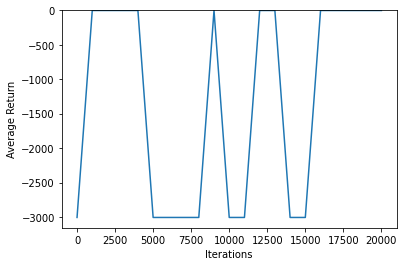

In [ ]:
# Hyper-parameters
num_iterations = 20000  # @param {type:"integer"}

collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 256  # @param {type:"integer"}

learning_rate = 1e-3  # @param {type:"number"}
num_eval_episodes = 10  # @param {type:"integer"}

eval_interval = 1000  # @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}

train_env_gym = BuildAbandonOptionEnv() # american put env
eval_env_gym = BuildAbandonOptionEnv() # test case

train_env_wrap = gym_wrapper.GymWrapper(train_env_gym)
eval_env_wrap = gym_wrapper.GymWrapper(eval_env_gym)

train_env = tf_py_environment.TFPyEnvironment(train_env_wrap)
eval_env = tf_py_environment.TFPyEnvironment(eval_env_wrap)

fc_layer_params = (200,) # number of hidden layers

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# the buffer will update the Q table based on not only the past one step, but some older steps as well.

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

# eval_env evaluation

# computer average return of the Q network, which in our case is the reward, which is premium option price
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for i in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

# Data Collection

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)

# common loop in RL- especailly DQN
def collect_data(env, policy, buffer, steps):
    for i in range(steps):
        collect_step(env, policy, buffer)

# training!!
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for i in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for j in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

# plot training iterations
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2)

# save policy
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

saved_policy = tf.compat.v2.saved_model.load(policy_dir)

In [ ]:
pricing_dict = {}
npv = compute_avg_return(eval_env, agent.policy, num_episodes=100) # not averaged
pricing_dict['RL-DQN - 10000 Path'] = npv
pricing_dict

IndexError: ignored